# Task 0 

Analyze the spatial and temporal patterns of fire events. 

Identify trends, anomalies, and key insights that can help understand the distribution and frequency of fire incidents over space and time.

In [1]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


westmidland boundries

In [42]:
boudary_wm = gpd.read_file('../data/westmidslands/westmidlands.shp')
oa_uk = gpd.read_file('../data/westmidslands/Output_Area/Output_Area_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp')
oa_uk = oa_uk.to_crs(epsg=27700)

In [109]:
# intersection of the two shapefiles
oa_wm = gpd.overlay(boudary_wm, oa_uk, how='intersection')


<Axes: >

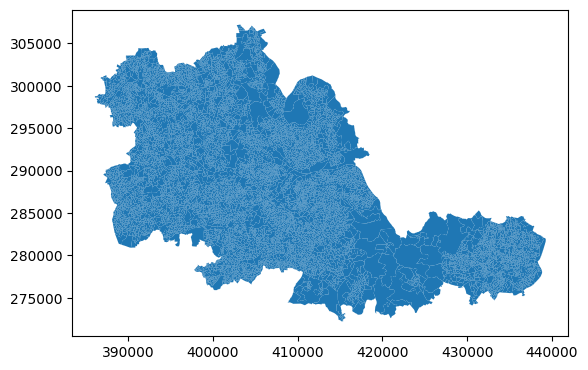

In [80]:
oa_wm.plot()

In [110]:
incident = pd.read_csv('../data/processed/incident_14_22.csv')
incident.head()

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,call_hour,call_day,call_month,call_year
0,2014-08-05 00:51:11,Other type of accidental fire,High Risk,FIRE,1,0,429008.867960,279466.431647,78,81,267.0,0,1,8,2014
1,2014-08-05 01:53:23,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,400060.417513,291291.512584,57,104,175.0,1,1,8,2014
2,2014-08-05 02:04:43,Gas leak,High Risk,SSC,2,0,397304.803476,289145.924308,102,149,311.0,2,1,8,2014
3,2014-08-05 02:09:56,False alarm raised with good intent,False Alarms,FALSE_ALARM,0,1,404480.191871,289576.642513,70,85,393.0,2,1,8,2014
4,2014-08-05 02:59:36,Deliberate Rubbish Fires,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,433324.298276,282473.140722,54,278,156.0,2,1,8,2014


In [8]:
print(incident.describe())

           prl_count      brv_count       EASTINGS      NORTHINGS  \
count  219926.000000  219926.000000  219926.000000  219926.000000   
mean        0.859821       0.493398  406509.368567  288784.079032   
std         0.906735       0.519800   12051.328379    7014.123106   
min         0.000000       0.000000  386159.376502  272135.394576   
25%         0.000000       0.000000  398064.465872  283391.547720   
50%         1.000000       0.000000  405022.851969  288036.498892   
75%         1.000000       1.000000  411429.394776  293871.458996   
max        34.000000      13.000000  439383.984557  307318.670460   

        call_seconds  reaction_seconds  driving_seconds      call_hour  \
count  219926.000000     219926.000000    219926.000000  219926.000000   
mean      136.034712         73.607918       298.035607      13.996317   
std      1526.065871        205.535917       466.539120       6.272446   
min         0.000000          0.000000         0.000000       0.000000   
25%     

autocorrelation

In [111]:

incident['geometry'] = [Point(xy) for xy in zip(incident['EASTINGS'], incident['NORTHINGS'])]
incident = gpd.GeoDataFrame(incident, crs='EPSG:27700')
incident


,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,call_hour,call_day,call_month,call_year,geometry
0,2014-08-05 00:51:11,Other type of accidental fire,High Risk,FIRE,1,0,429008.867960,279466.431647,78,81,267.0,0,1,8,2014,POINT (429008.868 279466.432)
1,2014-08-05 01:53:23,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,400060.417513,291291.512584,57,104,175.0,1,1,8,2014,POINT (400060.418 291291.513)
2,2014-08-05 02:04:43,Gas leak,High Risk,SSC,2,0,397304.803476,289145.924308,102,149,311.0,2,1,8,2014,POINT (397304.803 289145.924)
3,2014-08-05 02:09:56,False alarm raised with good intent,False Alarms,FALSE_ALARM,0,1,404480.191871,289576.642513,70,85,393.0,2,1,8,2014,POINT (404480.192 289576.643)
4,2014-08-05 02:59:36,Deliberate Rubbish Fires,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,433324.298276,282473.140722,54,278,156.0,2,1,8,2014,POINT (433324.298 282473.141)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219921,2022-12-30 22:19:38,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,396345.990934,285638.456376,44,43,326.0,22,4,12,2022,POINT (396345.991 285638.456)
219922,2022-12-30 22:50:29,Road Traffic Collision,High Risk,RTC,1,0,389714.735082,295657.525190,140,64,245.0,22,4,12,2022,POINT (389714.735 295657.525)
219923,2022-12-30 22:51:24,"Water incident (flooding, leaks, rescues etc.)",Low Risk,SSC,1,0,405460.670697,286385.402222,217,59,147.0,22,4,12,2022,POINT (405460.671 286385.402)
219924,2022-12-30 22:50:13,False Alarms (Equipment),Medium Risk,FALSE_ALARM,0,1,411729.868502,286839.226566,51,141,187.0,22,4,12,2022,POINT (411729.869 286839.227)


In [112]:
# calculate the number of incidents in each OA
incident_oa = gpd.sjoin(incident, oa_wm, op='within')
incident_oa = incident_oa.groupby('oa11cd').size().reset_index(name='incident_count')
incident_oa = incident_oa.rename(columns={'oa11cd': 'oa11cd', 'incident_count': 'incident_count'})
incident_oa


C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,oa11cd,incident_count
0,E00045077,24
1,E00045078,11
2,E00045079,34
3,E00045080,46
4,E00045081,28
...,...,...
8466,E00175799,26
8467,E00175800,102
8468,E00175801,14
8469,E00175802,7


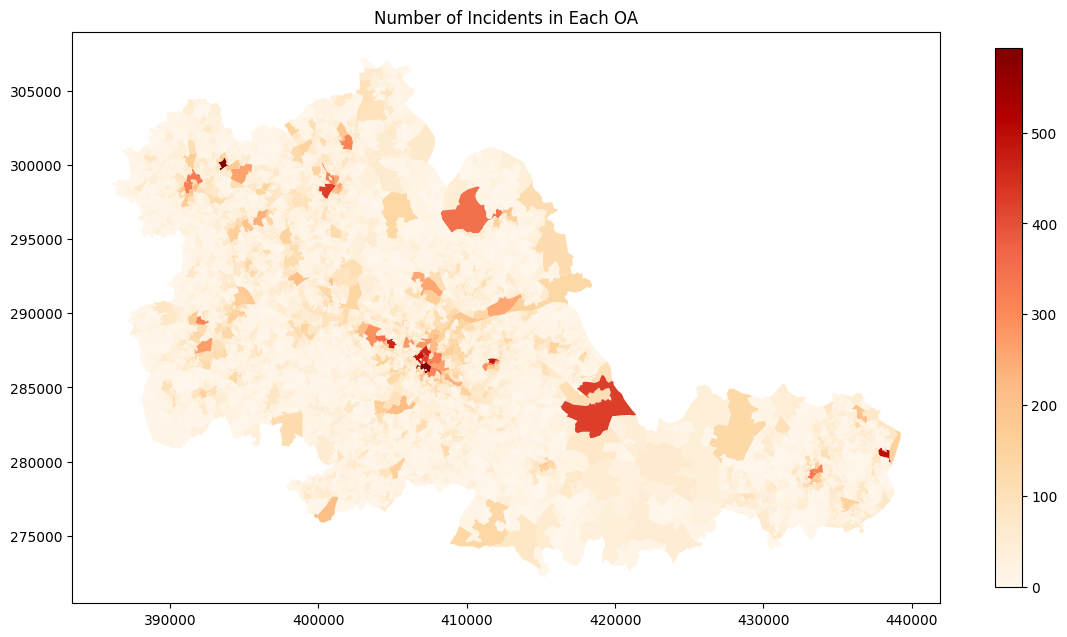

In [113]:
# Merging the data
incident_oa = oa_wm.merge(incident_oa, on='oa11cd', how='left')
incident_oa = incident_oa.fillna(0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
incident_oa.plot(column='incident_count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'shrink': 0.5})
ax.set_title('Number of Incidents in Each OA')
plt.show()

In [119]:
high_risk = incident[incident['incident_profile_label'] == 'High Risk']
low_risk = incident[incident['incident_profile_label'] == 'Low Risk']
medium_risk = incident[incident['incident_profile_label'] == 'Medium Risk']
false_alarm = incident[incident['incident_profile_label'] == 'False Alarms']
Secondary_fires = incident[incident['incident_profile_label'] == 'Secondary Fires that attract a 20 minute-response time']

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


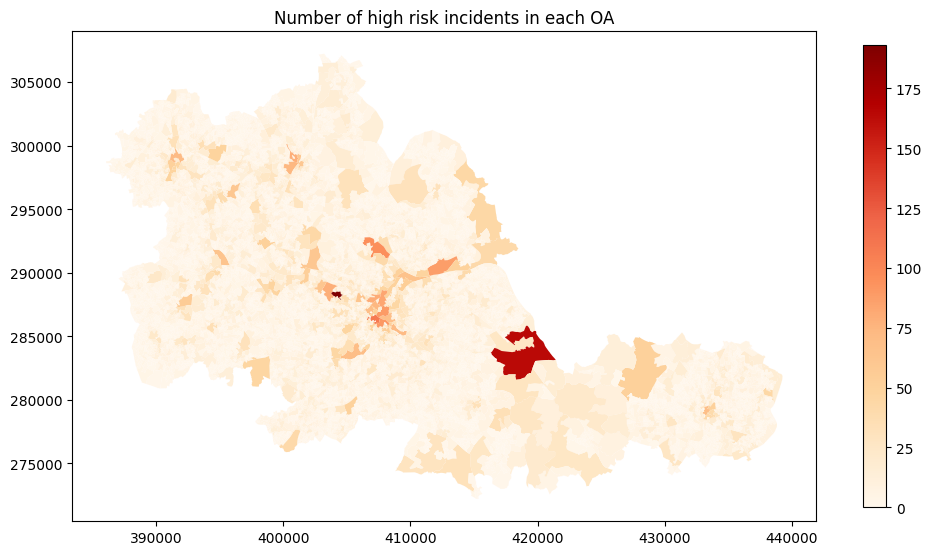

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


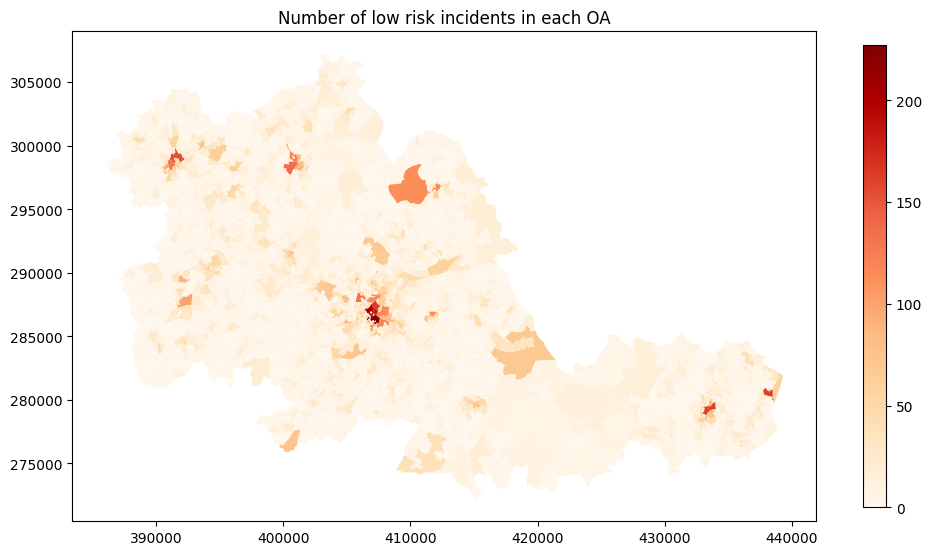

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


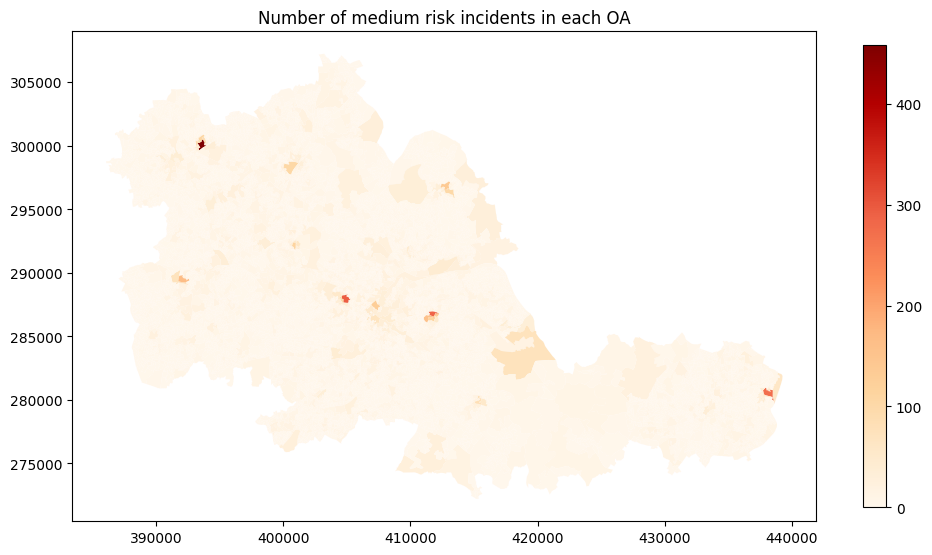

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


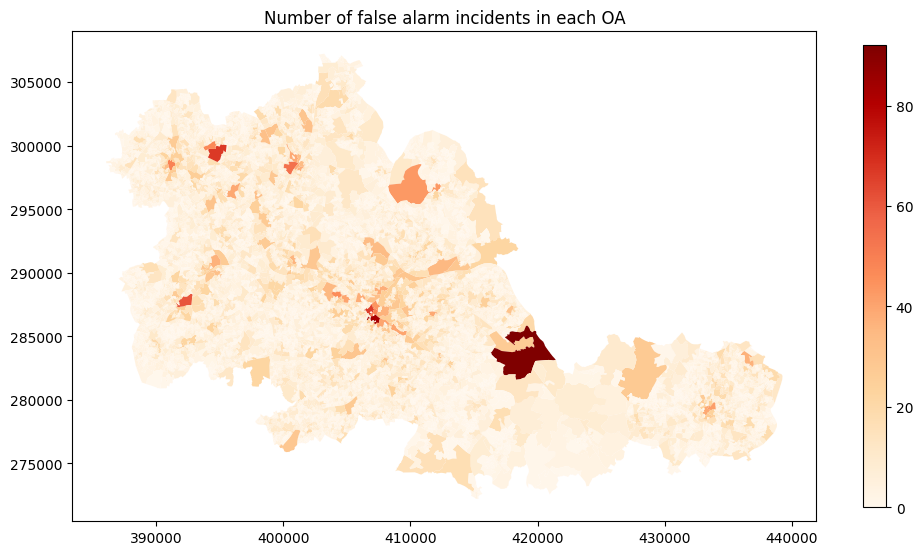

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


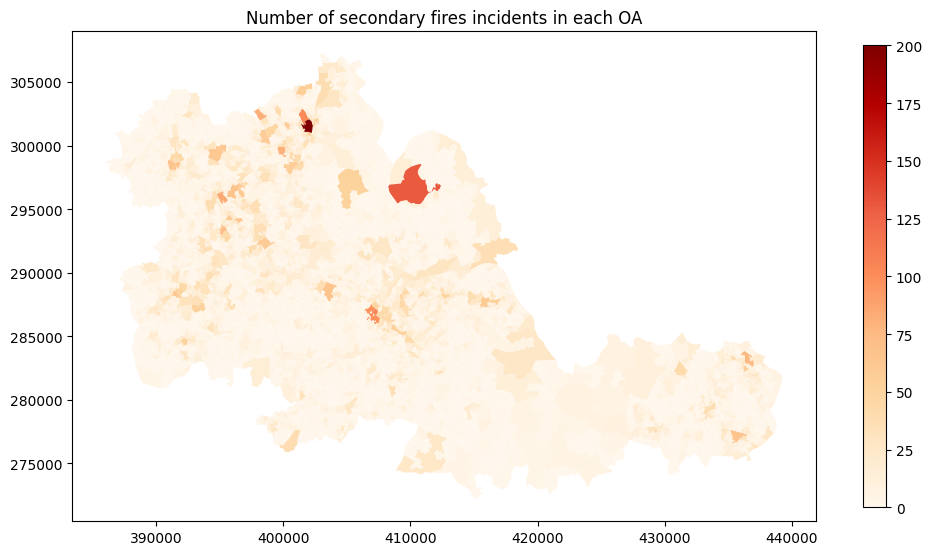

In [122]:
# plot the number of high risk incidents in each OA
high_risk_oa = gpd.sjoin(high_risk, oa_wm, op='within')
high_risk_oa = high_risk_oa.groupby('oa11cd').size().reset_index(name='high_risk_count')
high_risk_oa = high_risk_oa.rename(columns={'oa11cd': 'oa11cd', 'high_risk_count': 'high_risk_count'})
high_risk_oa = oa_wm.merge(high_risk_oa, on='oa11cd', how='left')
high_risk_oa = high_risk_oa.fillna(0)
high_risk_oa.plot(column='high_risk_count', legend=True, figsize=(12, 12), cmap='OrRd', legend_kwds={'shrink': 0.5})
plt.title('Number of high risk incidents in each OA')
plt.show()

# plot the number of low risk incidents in each OA
low_risk_oa = gpd.sjoin(low_risk, oa_wm, op='within')
low_risk_oa = low_risk_oa.groupby('oa11cd').size().reset_index(name='low_risk_count')
low_risk_oa = low_risk_oa.rename(columns={'oa11cd': 'oa11cd', 'low_risk_count': 'low_risk_count'})
low_risk_oa = oa_wm.merge(low_risk_oa, on='oa11cd', how='left')
low_risk_oa = low_risk_oa.fillna(0)
low_risk_oa.plot(column='low_risk_count', legend=True, figsize=(12, 12), cmap='OrRd', legend_kwds={'shrink': 0.5})
plt.title('Number of low risk incidents in each OA')
plt.show()

# plot the number of medium risk incidents in each OA
medium_risk_oa = gpd.sjoin(medium_risk, oa_wm, op='within')
medium_risk_oa = medium_risk_oa.groupby('oa11cd').size().reset_index(name='medium_risk_count')
medium_risk_oa = medium_risk_oa.rename(columns={'oa11cd': 'oa11cd', 'medium_risk_count': 'medium_risk_count'})
medium_risk_oa = oa_wm.merge(medium_risk_oa, on='oa11cd', how='left')
medium_risk_oa = medium_risk_oa.fillna(0)
medium_risk_oa.plot(column='medium_risk_count', legend=True, figsize=(12, 12), cmap='OrRd', legend_kwds={'shrink': 0.5})
plt.title('Number of medium risk incidents in each OA')
plt.show()

# plot the number of false alarm incidents in each OA
false_alarm_oa = gpd.sjoin(false_alarm, oa_wm, op='within')
false_alarm_oa = false_alarm_oa.groupby('oa11cd').size().reset_index(name='false_alarm_count')
false_alarm_oa = false_alarm_oa.rename(columns={'oa11cd': 'oa11cd', 'false_alarm_count': 'false_alarm_count'})
false_alarm_oa = oa_wm.merge(false_alarm_oa, on='oa11cd', how='left')
false_alarm_oa = false_alarm_oa.fillna(0)
false_alarm_oa.plot(column='false_alarm_count', legend=True, figsize=(12, 12), cmap='OrRd', legend_kwds={'shrink': 0.5})
plt.title('Number of false alarm incidents in each OA')
plt.show()

# plot the number of secondary fires incidents in each OA
Secondary_fires_oa = gpd.sjoin(Secondary_fires, oa_wm, op='within')
Secondary_fires_oa = Secondary_fires_oa.groupby('oa11cd').size().reset_index(name='Secondary_fires_count')
Secondary_fires_oa = Secondary_fires_oa.rename(columns={'oa11cd': 'oa11cd', 'Secondary_fires_count': 'Secondary_fires_count'})
Secondary_fires_oa = oa_wm.merge(Secondary_fires_oa, on='oa11cd', how='left')
Secondary_fires_oa = Secondary_fires_oa.fillna(0)
Secondary_fires_oa.plot(column='Secondary_fires_count', legend=True, figsize=(12, 12), cmap='OrRd', legend_kwds={'shrink': 0.5})
plt.title('Number of secondary fires incidents in each OA')
plt.show()


In [129]:
oa_wm

,NAME,DESCRIPTIO,objectid,oa11cd,lad11cd,st_areasha,st_lengths,geometry
0,West Midlands,Ceremonial County,43681,E00045077,E08000025,108652.477794,1619.366208,"POLYGON ((413028.225 284148.393, 413100.811 28..."
1,West Midlands,Ceremonial County,43682,E00045078,E08000025,53561.346407,1138.972340,"POLYGON ((412950.167 283627.532, 412847.210 28..."
2,West Midlands,Ceremonial County,43683,E00045079,E08000025,46396.193461,871.221255,"POLYGON ((412233.891 283200.861, 412122.352 28..."
3,West Midlands,Ceremonial County,43684,E00045080,E08000025,102432.198912,1546.870365,"POLYGON ((411823.386 283952.631, 411804.387 28..."
4,West Midlands,Ceremonial County,43685,E00045081,E08000025,51331.305299,1871.479740,"POLYGON ((411597.488 283804.574, 411583.200 28..."
...,...,...,...,...,...,...,...,...
8599,West Midlands,Ceremonial County,170397,E00175799,E08000025,163813.883521,1991.881441,"POLYGON ((400602.597 281861.997, 400657.443 28..."
8600,West Midlands,Ceremonial County,170398,E00175800,E08000025,295408.956482,3417.194772,"POLYGON ((404001.332 282830.723, 403827.393 28..."
8601,West Midlands,Ceremonial County,170399,E00175801,E08000025,32718.054283,1630.831535,"POLYGON ((403896.948 282652.772, 403777.860 28..."
8602,West Midlands,Ceremonial County,170400,E00175802,E08000025,11041.023262,680.827582,"POLYGON ((404833.381 282380.208, 404688.258 28..."


In [130]:
import pandas as pd
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights



# 将incident数据转换为geopandas GeoDataFrame
incident = gpd.GeoDataFrame(incident, geometry=gpd.points_from_xy(incident.EASTINGS, incident.NORTHINGS), crs=oa_wm.crs)

# 使用space join将incident数据和oa_wm数据合并
joined_gdf = gpd.sjoin(incident, oa_wm, how="inner", op="within")

# 创建空间权重矩阵
w = weights.Queen.from_dataframe(joined_gdf)

# 计算莫兰指数
moran = esda.Moran(joined_gdf["incident_classification_label"], w)

# 打印全局莫兰指数
print("全局莫兰指数 (Moran's I):", moran.I)

# 计算局部莫兰指数
local_moran = esda.Moran_Local(joined_gdf["incident_classification_label"], w)

# 打印前5个局部莫兰指数
print("前5个局部莫兰指数 (Local Moran's I):")
print(local_moran.Is[:5])


C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\dune\AppData\Local\Temp\ipykernel_19860\2810548425.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(joined_gdf)


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [131]:
joined_gdf

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,...,call_year,geometry,index_right,NAME,DESCRIPTIO,objectid,oa11cd,lad11cd,st_areasha,st_lengths
0,2014-08-05 00:51:11,Other type of accidental fire,High Risk,FIRE,1,0,429008.867960,279466.431647,78,81,...,2014,POINT (429008.868 279466.432),3889,West Midlands,Ceremonial County,47570,E00049108,E08000026,58347.164075,1341.840802
1,2014-08-05 01:53:23,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,400060.417513,291291.512584,57,104,...,2014,POINT (400060.418 291291.513),5821,West Midlands,Ceremonial County,49502,E00051075,E08000028,112168.596488,2049.699515
2,2014-08-05 02:04:43,Gas leak,High Risk,SSC,2,0,397304.803476,289145.924308,102,149,...,2014,POINT (397304.803 289145.924),5728,West Midlands,Ceremonial County,49409,E00050981,E08000028,69026.162808,1444.389846
3,2014-08-05 02:09:56,False alarm raised with good intent,False Alarms,FALSE_ALARM,0,1,404480.191871,289576.642513,70,85,...,2014,POINT (404480.192 289576.643),2252,West Midlands,Ceremonial County,45933,E00047418,E08000025,92278.806435,1346.122241
4,2014-08-05 02:59:36,Deliberate Rubbish Fires,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,433324.298276,282473.140722,54,278,...,2014,POINT (433324.298 282473.141),3333,West Midlands,Ceremonial County,47014,E00048528,E08000026,237680.419023,3319.528898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219921,2022-12-30 22:19:38,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,396345.990934,285638.456376,44,43,...,2022,POINT (396345.991 285638.456),5124,West Midlands,Ceremonial County,48805,E00050358,E08000028,110944.612587,1789.850944
219922,2022-12-30 22:50:29,Road Traffic Collision,High Risk,RTC,1,0,389714.735082,295657.525190,140,64,...,2022,POINT (389714.735 295657.525),7801,West Midlands,Ceremonial County,51482,E00053099,E08000031,62873.030060,1383.036149
219923,2022-12-30 22:51:24,"Water incident (flooding, leaks, rescues etc.)",Low Risk,SSC,1,0,405460.670697,286385.402222,217,59,...,2022,POINT (405460.671 286385.402),8439,West Midlands,Ceremonial County,170237,E00175639,E08000025,30300.630479,790.747469
219924,2022-12-30 22:50:13,False Alarms (Equipment),Medium Risk,FALSE_ALARM,0,1,411729.868502,286839.226566,51,141,...,2022,POINT (411729.869 286839.227),2172,West Midlands,Ceremonial County,45853,E00047335,E08000025,172684.413217,2339.111786


In [ ]:
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights


# 计算Getis-Ord Gi*统计量
hotspot = esda.G_Local(joined_gdf["incident_classification_label"], w)

# 获取统计量的p值
p_values = hotspot.p_sim

# 将结果添加到GeoDataFrame中
joined_gdf['hotspot_p_value'] = p_values

# 选择p值小于0.05的区域作为火灾高发区域
hotspots = joined_gdf[joined_gdf['hotspot_p_value'] < 0.05]

# 保存结果
hotspots.to_file("fire_hotspots.shp")


In [ ]:
# 设置核密度估计的带宽参数
bandwidth = 0.01

# 提取火灾事件的坐标
coordinates = np.vstack([incident_gdf.geometry.x, incident_gdf.geometry.y]).T

# 创建核密度估计模型
kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='gaussian', algorithm='auto')

# 将火灾事件的坐标拟合到模型中
kde.fit(coordinates)

# 生成用于绘制密度热力图的网格点
x_min, y_min, x_max, y_max = incident_gdf.total_bounds
x_values = np.linspace(x_min, x_max, 100)
y_values = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_values, y_values)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# 计算每个网格点的密度
densities = np.exp(kde.score_samples(grid_points))
density_grid = densities.reshape(X.shape)

# 绘制密度热力图
plt.figure(figsize=(10, 8))
plt.imshow(density_grid, cmap='hot', extent=[x_min, x_max, y_min, y_max], origin='lower')
plt.colorbar(label='Density')
plt.title('Kernel Density Estimation of Fire Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [142]:
from matplotlib.patches import Ellipse
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors

# 提取火灾事件的坐标
coordinates = np.array([incident['EASTINGS'], incident['NORTHINGS']]).T

# 创建KDTree来计算最近邻距离
kdtree = cKDTree(coordinates)

# 查询每个点的最近邻距离，k=2表示查询第二近的邻居，因为最近邻是自身
avg_dist, _ = kdtree.query(coordinates, k=2)

# 去除重复点
unique_distances = np.unique(avg_dist[:, 1])

# 检查标准差是否为零
if np.std(unique_distances) == 0:
    print("无法确定分布类型，所有点可能位于同一位置。")
else:
    # 计算平均最近邻距离
    avg_nn_distance = np.mean(avg_dist[:, 1])

    # 计算平均距离的标准差
    std_nn_distance = np.std(avg_dist[:, 1])

    # 计算Z值
    z_score = (avg_nn_distance - np.mean(avg_dist[:, 1])) / np.std(avg_dist[:, 1])

    # 根据Z值判断分布类型
    if z_score < -1.96:
        print("火灾事件呈现聚集分布")
    elif z_score > 1.96:
        print("火灾事件呈现分散分布")
    else:
        print("火灾事件呈现随机分布")

火灾事件呈现随机分布


## temporal analysis

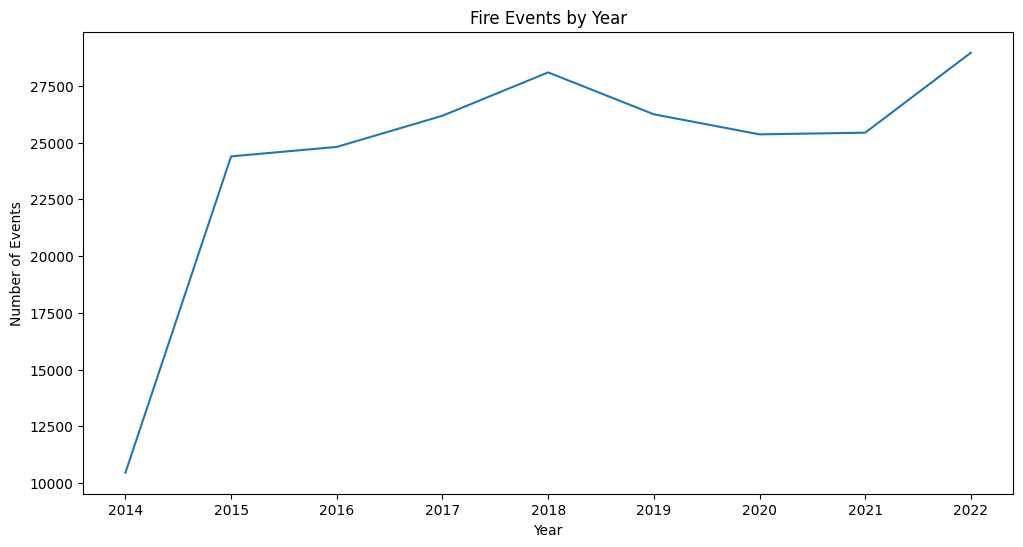

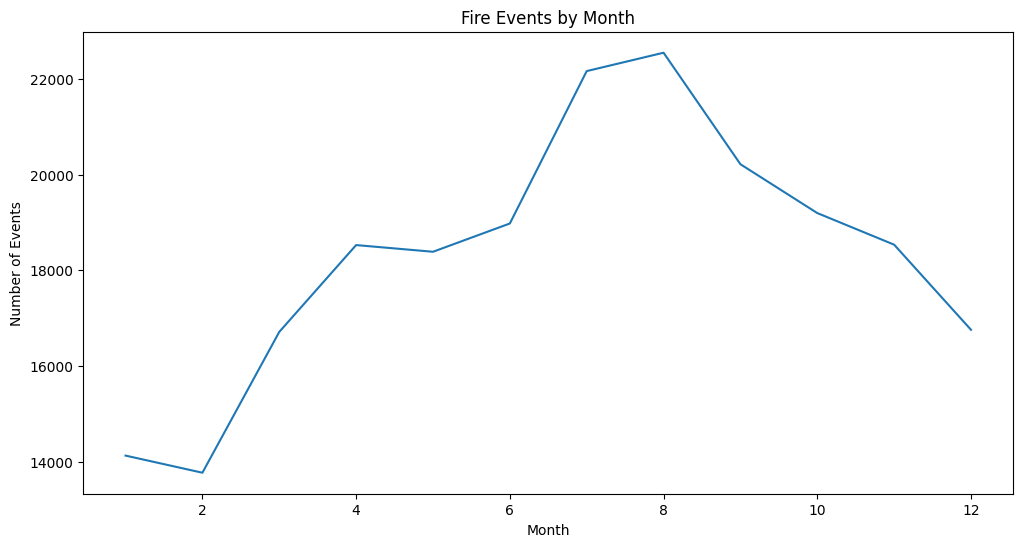

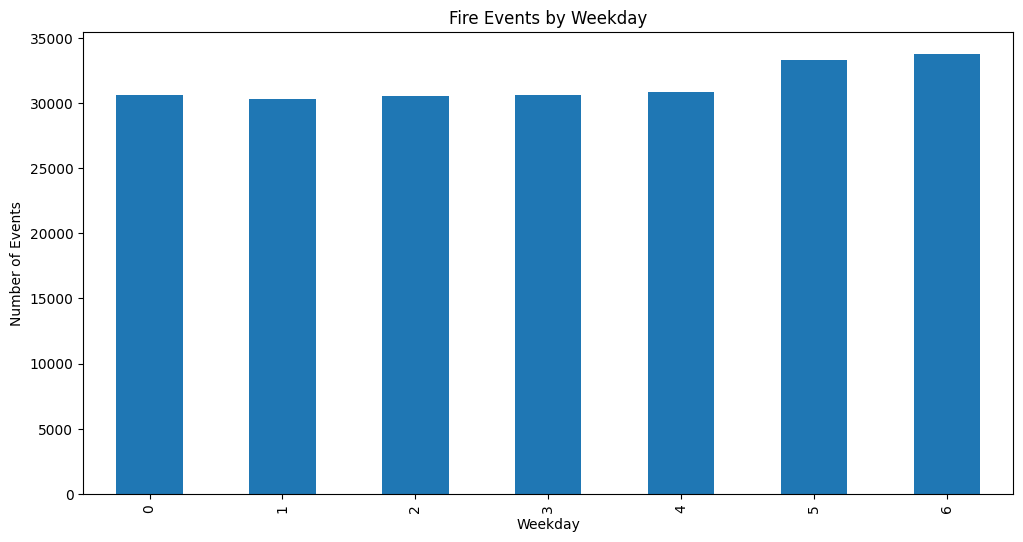

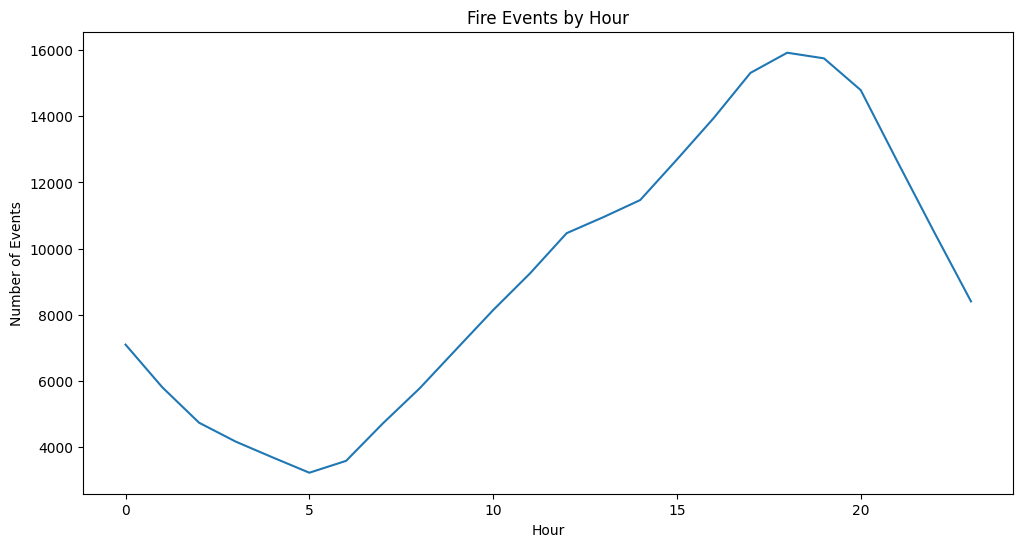

In [25]:

yearly_counts = incident['call_year'].value_counts().sort_index()
yearly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Year')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.show()

monthly_counts = incident['call_month'].value_counts().sort_index()
monthly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.show()

weekday_counts = incident['call_day'].value_counts().sort_index()
weekday_counts.plot(kind='bar', figsize=(12, 6), title='Fire Events by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Events')
plt.show()

hourly_counts = incident['call_hour'].value_counts().sort_index()
hourly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.show()



In [26]:
'''# different incident profiles
incident_profiles = incident.groupby('incident_profile_label')

for profile, group in incident_profiles:
    print(f"incident level: {profile}")
    
    yearly_counts = group['call_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    yearly_counts.plot(kind='line')
    plt.title(f'Fire Events by Year ({profile})')
    plt.xlabel('Year')
    plt.ylabel('Number of Events')
    plt.show()

    monthly_counts = group['call_month'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    monthly_counts.plot(kind='line')
    plt.title(f'Fire Events by Month ({profile})')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.show()
    
    weekday_counts = group['call_day'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    weekday_counts.plot(kind='bar')
    plt.title(f'Fire Events by Weekday ({profile})')
    plt.xlabel('Weekday')
    plt.ylabel('Number of Events')
    plt.show()
    
    hourly_counts = group['call_hour'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    hourly_counts.plot(kind='line')
    plt.title(f'Fire Events by Hour ({profile})')
    plt.xlabel('Hour')
    plt.ylabel('Number of Events')
    plt.show()'''

'# different incident profiles\nincident_profiles = incident.groupby(\'incident_profile_label\')\n\nfor profile, group in incident_profiles:\n    print(f"incident level: {profile}")\n    \n    yearly_counts = group[\'call_year\'].value_counts().sort_index()\n    plt.figure(figsize=(10, 6))\n    yearly_counts.plot(kind=\'line\')\n    plt.title(f\'Fire Events by Year ({profile})\')\n    plt.xlabel(\'Year\')\n    plt.ylabel(\'Number of Events\')\n    plt.show()\n\n    monthly_counts = group[\'call_month\'].value_counts().sort_index()\n    plt.figure(figsize=(10, 6))\n    monthly_counts.plot(kind=\'line\')\n    plt.title(f\'Fire Events by Month ({profile})\')\n    plt.xlabel(\'Month\')\n    plt.ylabel(\'Number of Events\')\n    plt.show()\n    \n    weekday_counts = group[\'call_day\'].value_counts().sort_index()\n    plt.figure(figsize=(10, 6))\n    weekday_counts.plot(kind=\'bar\')\n    plt.title(f\'Fire Events by Weekday ({profile})\')\n    plt.xlabel(\'Weekday\')\n    plt.ylabel(\'Numb

Slice the dataset into 4:
1. High Risk Incidents
2. Medium Risk Incidents
3. Low Risk Incidents
4. False Alarm

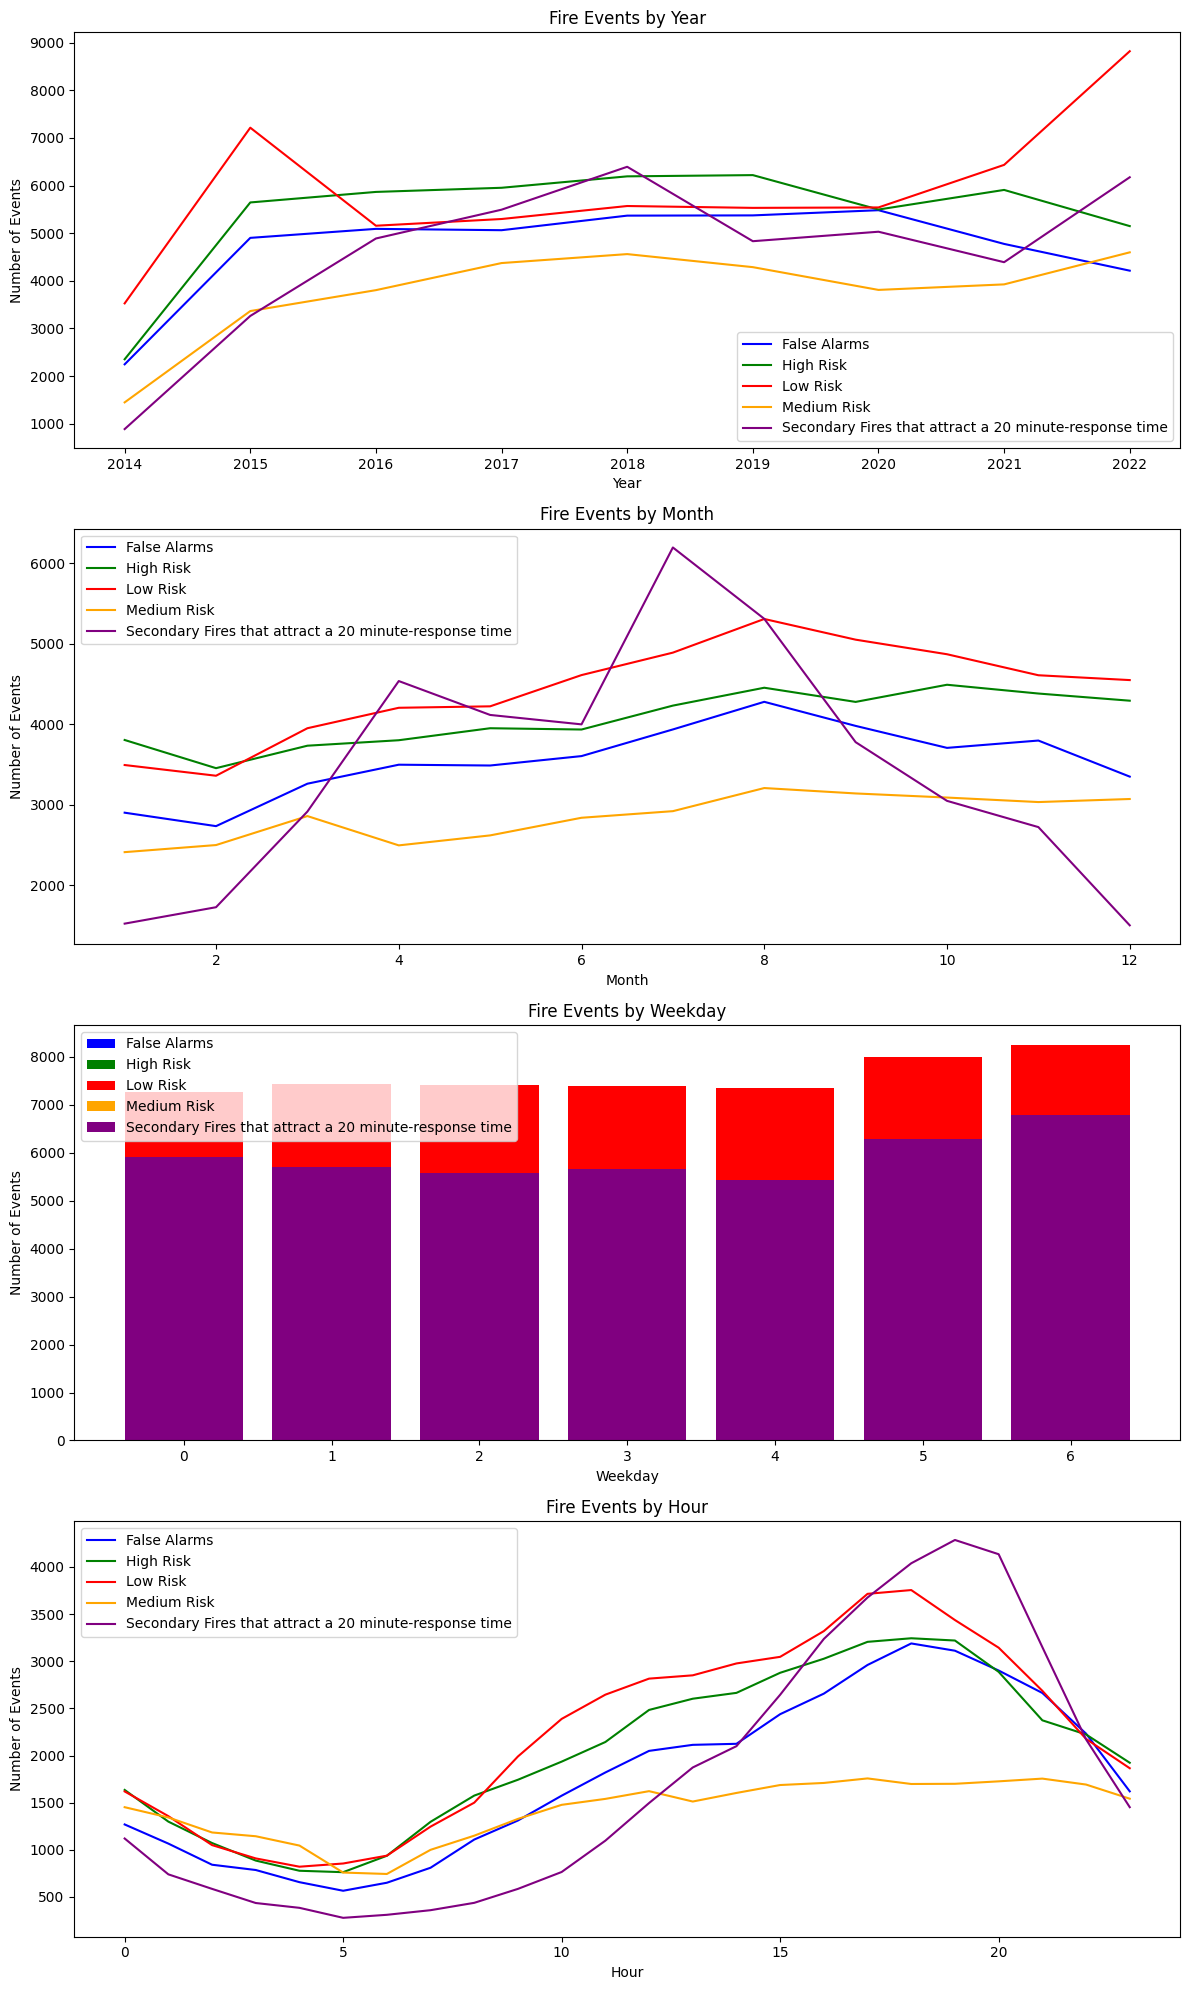

In [27]:
fig, axs = plt.subplots(4, figsize=(12, 20))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for idx, (profile, group) in enumerate(incident_profiles):

    yearly_counts = group['call_year'].value_counts().sort_index()
    axs[0].plot(yearly_counts.index, yearly_counts.values, label=profile, color=colors[idx])

    monthly_counts = group['call_month'].value_counts().sort_index()
    axs[1].plot(monthly_counts.index, monthly_counts.values, label=profile, color=colors[idx])

    weekday_counts = group['call_day'].value_counts().sort_index()
    axs[2].bar(weekday_counts.index, weekday_counts.values, label=profile, color=colors[idx])

    hourly_counts = group['call_hour'].value_counts().sort_index()
    axs[3].plot(hourly_counts.index, hourly_counts.values, label=profile, color=colors[idx])

axs[0].set_title('Fire Events by Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Events')
axs[0].legend()
axs[1].set_title('Fire Events by Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Number of Events')
axs[1].legend()
axs[2].set_title('Fire Events by Weekday')
axs[2].set_xlabel('Weekday')
axs[2].set_ylabel('Number of Events')
axs[2].legend()
axs[3].set_title('Fire Events by Hour')
axs[3].set_xlabel('Hour')
axs[3].set_ylabel('Number of Events')
axs[3].legend()

plt.tight_layout()
plt.show()


### Seasonal Decomposition

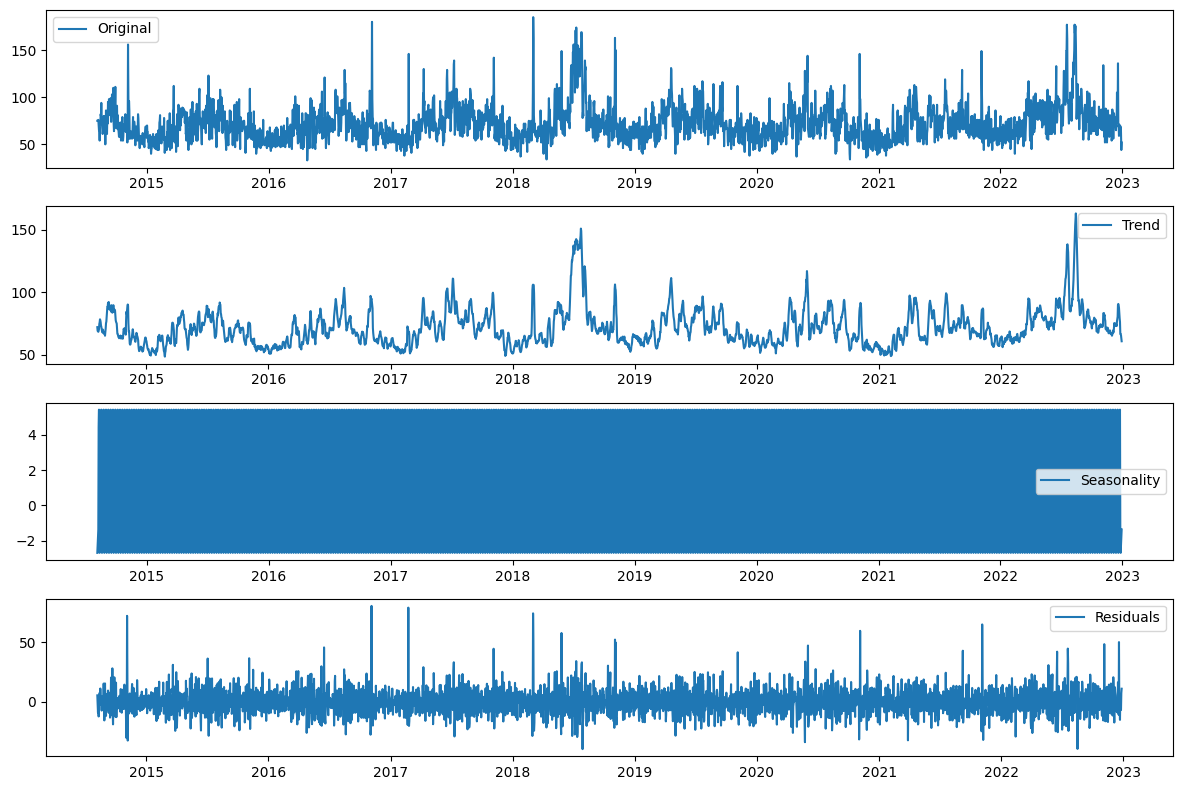

In [12]:
incident['call_time'] = pd.to_datetime(incident['call_time'])
incident.set_index('call_time', inplace=True)
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Perform seasonal decomposition
decomposition = seasonal_decompose(incidents_per_day, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

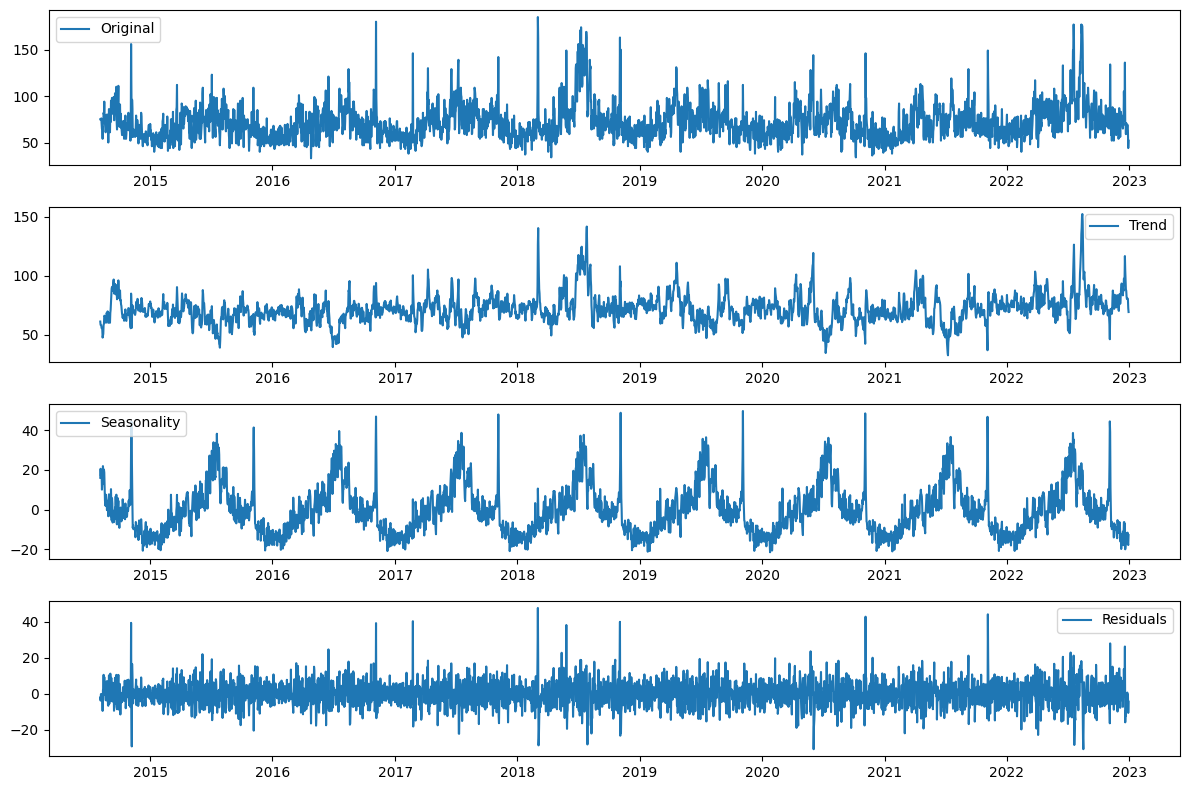

In [13]:
# Fit exponential smoothing model
model = ExponentialSmoothing(incidents_per_day, seasonal='add', seasonal_periods=365)
model_fit = model.fit()

# Extract trend, seasonal, and residual components
trend = model_fit.level
seasonal = model_fit.season
residual = incidents_per_day - trend - seasonal

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

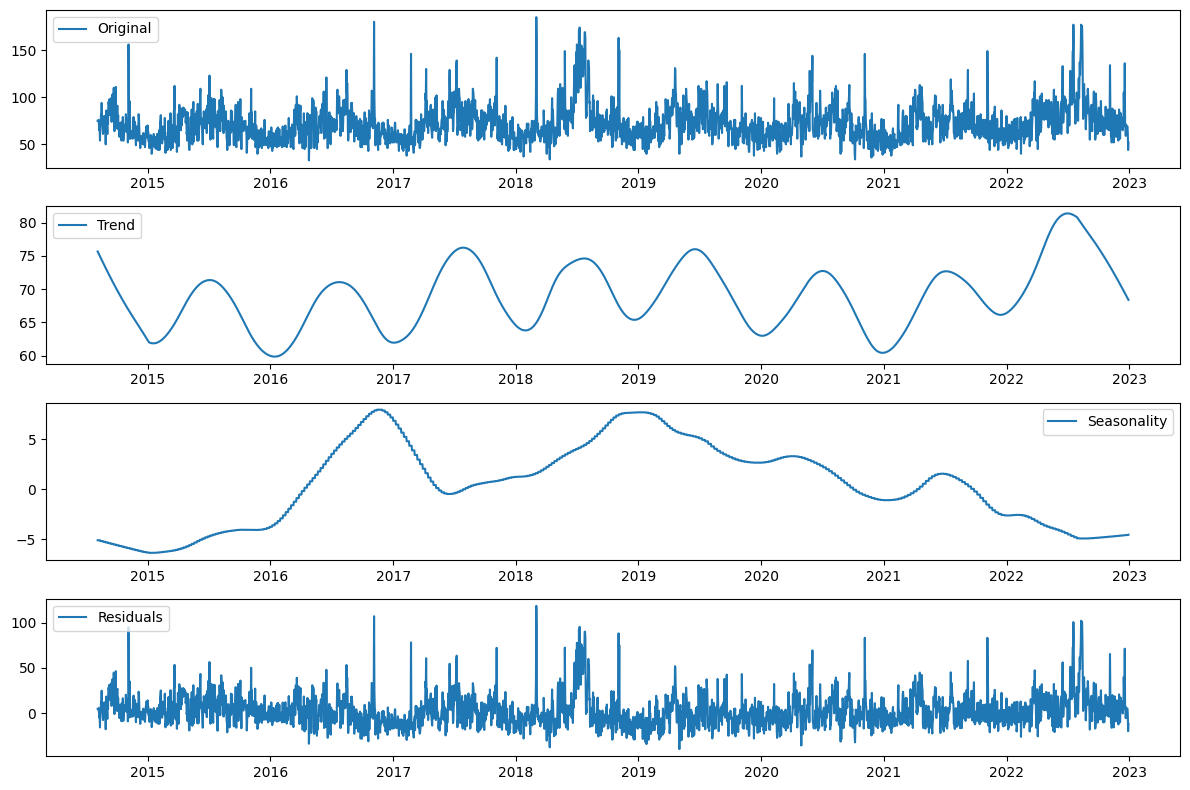

In [14]:
# Estimate trend using LOESS
trend = lowess(incidents_per_day, incidents_per_day.index, frac=0.1)[:, 1]

# Remove trend to get detrended data
detrended = incidents_per_day - trend

# Estimate seasonal component using LOESS on detrended data
seasonal = lowess(detrended, detrended.index.dayofyear, frac=0.1)[:, 1]

# Calculate residuals
residual = detrended - seasonal

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(incidents_per_day.index, trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(incidents_per_day.index, seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(incidents_per_day.index, residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


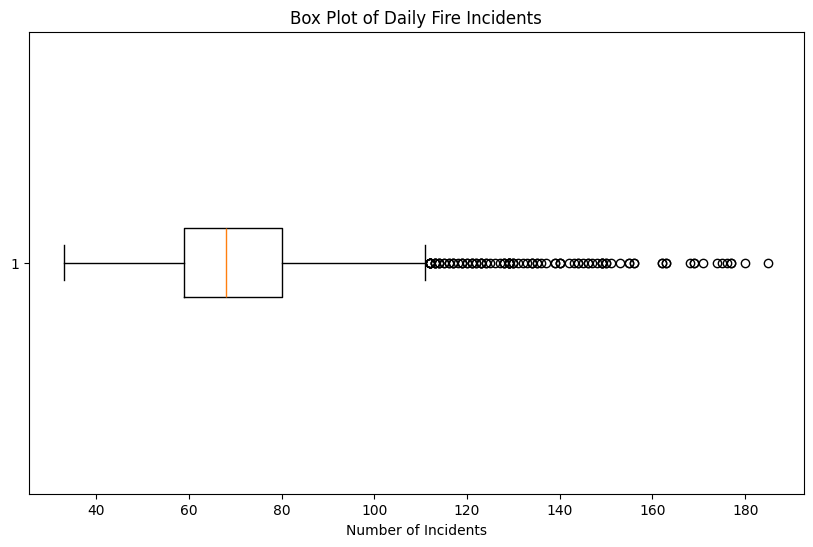

In [15]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Plot the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(incidents_per_day, vert=False)
plt.title('Box Plot of Daily Fire Incidents')
plt.xlabel('Number of Incidents')
plt.show()

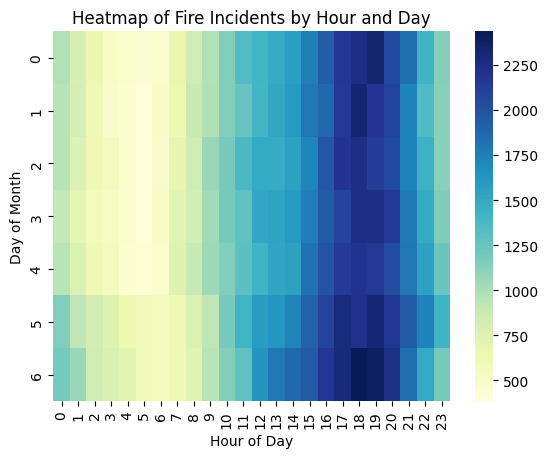

In [16]:
hourly_pivot = incident.pivot_table(values='prl_count', index='call_day', columns='call_hour', aggfunc='count')
sns.heatmap(hourly_pivot, cmap='YlGnBu')
plt.title('Heatmap of Fire Incidents by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Month')
plt.show()

### Outliers detection

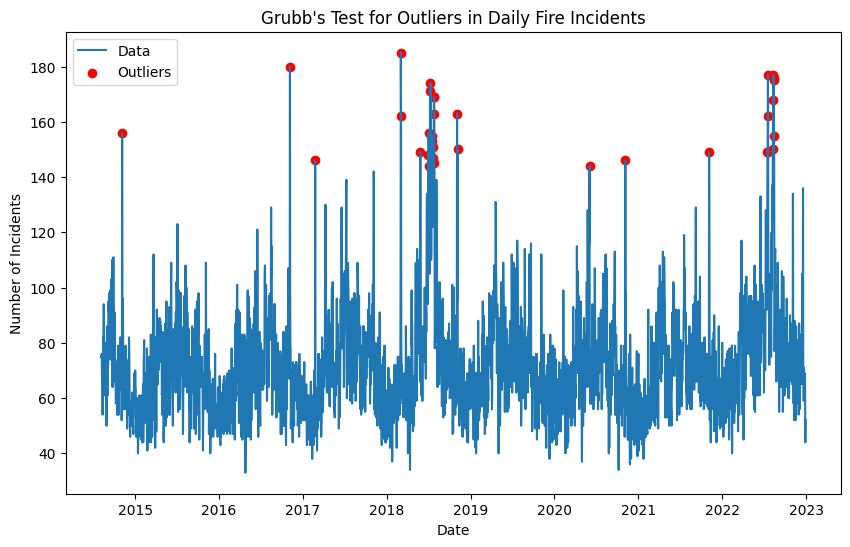

In [17]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Function to apply Grubb's test iteratively
def grubbs_test_series(data, alpha=0.05):
    outliers = []
    data_clean = data.copy()
    while True:
        n = len(data_clean)
        mean_y = np.mean(data_clean)
        std_y = np.std(data_clean)
        G = max(abs(data_clean - mean_y)) / std_y
        critical_value = stats.t.ppf(1 - alpha / (2 * n), n - 2) * (n - 1) / np.sqrt(n * (n - 2 + stats.t.ppf(1 - alpha / (2 * n), n - 2)**2))
        if G > critical_value:
            outlier_index = np.argmax(abs(data_clean - mean_y))
            outliers.append(data_clean.index[outlier_index])
            data_clean = data_clean.drop(data_clean.index[outlier_index])
        else:
            break
    return outliers

# Identify outliers
outlier_indices = grubbs_test_series(incidents_per_day)
outliers = incidents_per_day.loc[outlier_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incidents_per_day, label='Data')
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title("Grubb's Test for Outliers in Daily Fire Incidents")
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

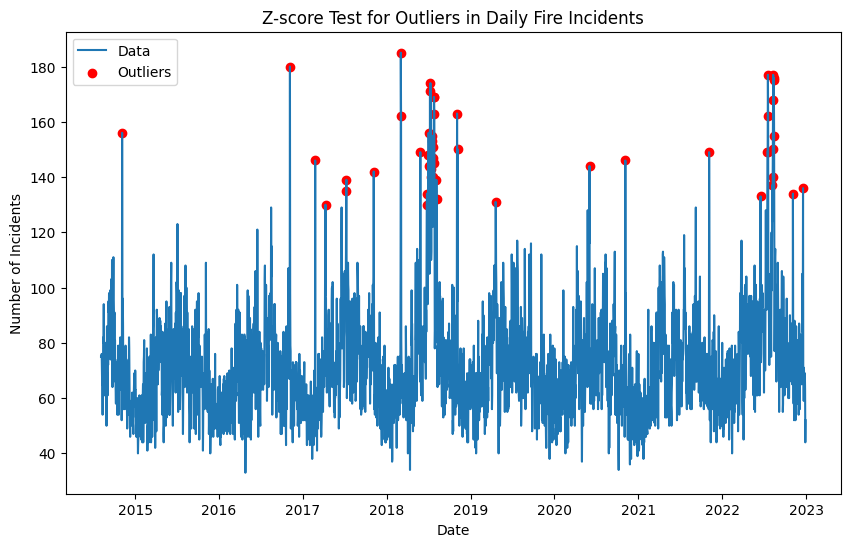

In [18]:
# Calculate Z-scores
z_scores = (incidents_per_day - incidents_per_day.mean()) / incidents_per_day.std()

# Define a threshold for Z-score
threshold = 3

# Identify outliers
outliers = incidents_per_day[np.abs(z_scores) > threshold]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incidents_per_day, label='Data')
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title('Z-score Test for Outliers in Daily Fire Incidents')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()


### predictive model

ARIMA

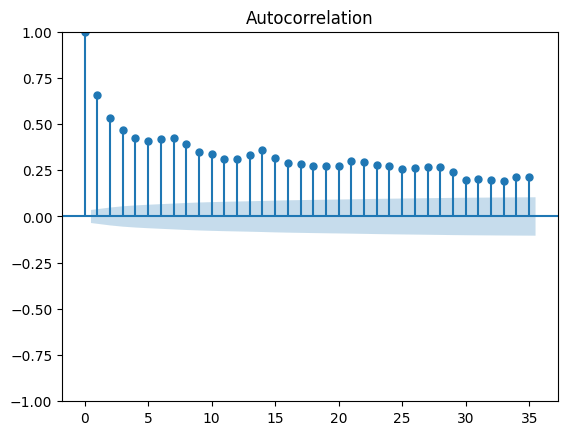

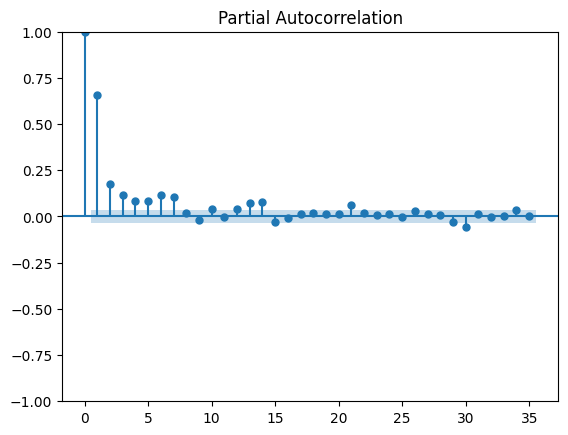

In [19]:
plot_acf(incidents_per_day)
plot_pacf(incidents_per_day)
plt.show()

In [20]:
model_arima = ARIMA(incidents_per_day, order=(1,0,0)) 
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3070
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -12558.847
Date:                Thu, 06 Jun 2024   AIC                          25123.695
Time:                        16:49:46   BIC                          25141.783
Sample:                    08-05-2014   HQIC                         25130.193
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.6370      0.881     81.297      0.000      69.910      73.364
ar.L1          0.6571      0.010     67.593      0.000       0.638       0.676
sigma2       209.3155      3.424     61.137      0.0

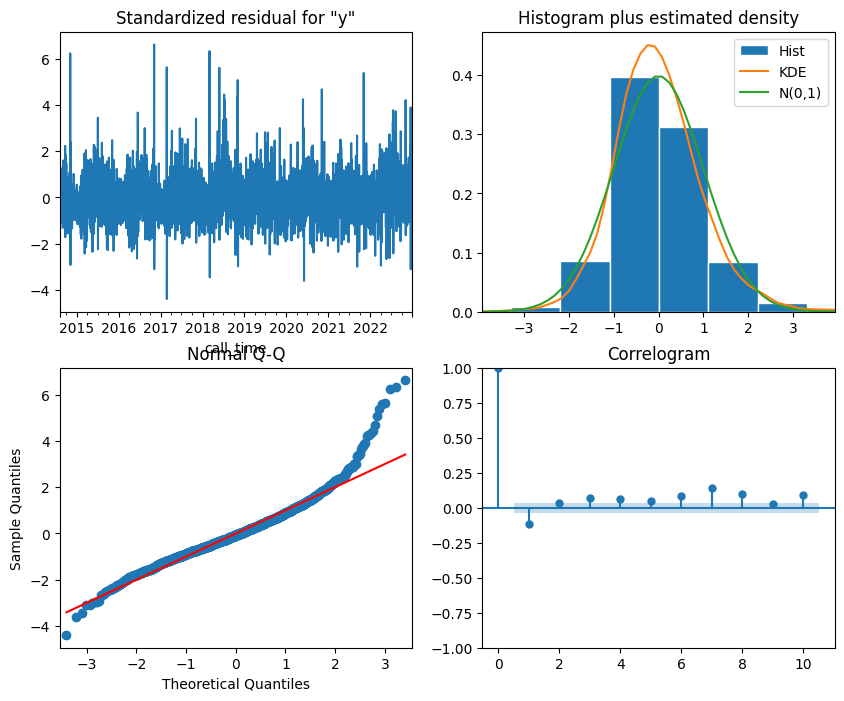

In [21]:
# Plot the residuals
model_arima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()


In [22]:
predictions_arima = model_arima_fit.forecast(steps=365) 
print(predictions_arima)


2022-12-31    58.733857
2023-01-01    63.158560
2023-01-02    66.065958
2023-01-03    67.976360
2023-01-04    69.231653
                ...    
2023-12-26    71.636993
2023-12-27    71.636993
2023-12-28    71.636993
2023-12-29    71.636993
2023-12-30    71.636993
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


Mean Squared Error: 973.2256324713749
Mean Absolute Error: 27.257141596167525


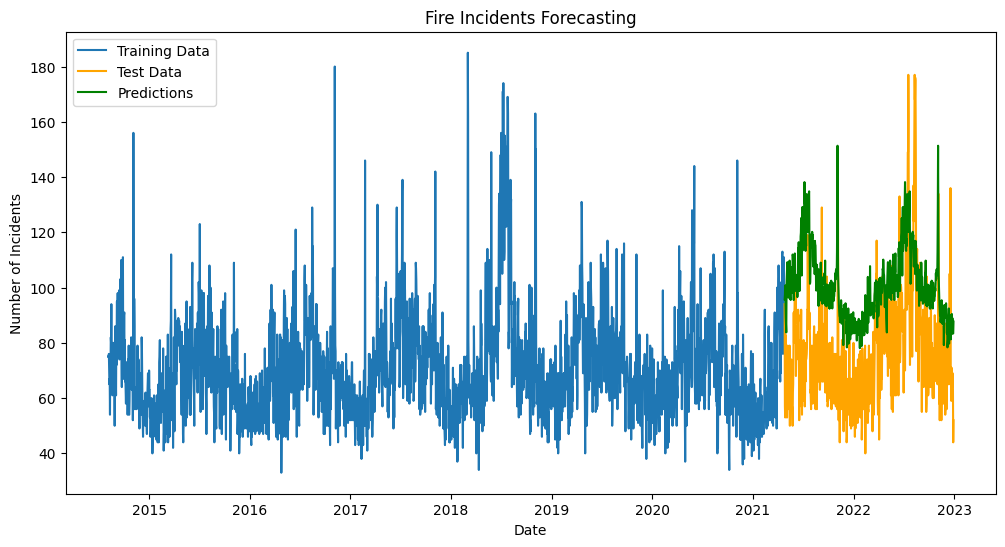

In [23]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Split the data into training and testing sets
train_size = int(len(incidents_per_day) * 0.8)
train_data, test_data = incidents_per_day[:train_size], incidents_per_day[train_size:]

# Fit the model
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions, label='Predictions', color='green')
plt.legend(loc='best')
plt.title('Fire Incidents Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()


In [28]:
from fbprophet import Prophet

train_data_prophet = pd.DataFrame({'ds': train_data_arima.index, 'y': train_data_arima.values})
test_data_prophet = pd.DataFrame({'ds': test_data_arima.index, 'y': test_data_arima.values})

# fit the model
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

# predict
future = model_prophet.make_future_dataframe(periods=len(test_data_arima))
forecast = model_prophet.predict(future)
predictions_prophet = forecast[-len(test_data_arima):]['yhat'].values

plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(test_data_arima.index, predictions_prophet, label='Prophet Predictions', color='blue')
plt.title('Prophet Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()



ModuleNotFoundError: No module named 'Prophet'

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape data for LSTM
train_data_lstm = np.array(train_data).reshape(-1, 1)
test_data_lstm = np.array(test_data).reshape(-1, 1)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit LSTM model
model_lstm.fit(train_data_lstm, train_data_lstm, epochs=100, batch_size=1, verbose=0)

# Make predictions
predictions_lstm = model_lstm.predict(test_data_lstm)
predictions_lstm = predictions_lstm.reshape(len(test_data))

# Evaluate the model
mse_lstm = mean_squared_error(test_data, predictions_lstm)
mae_lstm = mean_absolute_error(test_data, predictions_lstm)
print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM Mean Absolute Error: {mae_lstm}')






20/20 [==============================] - 1s 3ms/step
LSTM Mean Squared Error: 4.323359794235191e-08
LSTM Mean Absolute Error: 0.0001946116891668363


## spatial analysis

27700 to 4326

In [3]:
geometry = [Point(xy) for xy in zip(incident['EASTINGS'], incident['NORTHINGS'])]

incident_gdf = gpd.GeoDataFrame(incident, geometry=geometry)
incident_gdf.set_crs(epsg=27700, inplace=True)
incident_gdf = incident_gdf.to_crs(epsg=4326)

In [4]:
incident_gdf['geometry'] = incident_gdf['geometry'].astype(str)
incident_gdf['geometry'] = incident_gdf['geometry'].str.replace('POINT ', '').str.replace('(', '').str.replace(')', '')
incident_gdf[['X', 'Y']] = incident_gdf['geometry'].str.split(' ', expand=True)

incident_gdf['X'] = incident_gdf['X'].astype(float)
incident_gdf['Y'] = incident_gdf['Y'].astype(float)
incident_gdf = pd.DataFrame(incident_gdf)

C:\Users\dune\AppData\Local\Temp\ipykernel_19860\2105317320.py:1: UserWarning: Geometry column does not contain geometry.
  incident_gdf['geometry'] = incident_gdf['geometry'].astype(str)
C:\Users\dune\AppData\Local\Temp\ipykernel_19860\2105317320.py:2: UserWarning: Geometry column does not contain geometry.
  incident_gdf['geometry'] = incident_gdf['geometry'].str.replace('POINT ', '').str.replace('(', '').str.replace(')', '')


In [5]:
high_risk = incident_gdf[incident_gdf['incident_profile_label'] == 'High Risk']
low_risk = incident_gdf[incident_gdf['incident_profile_label'] == 'Low Risk']
medium_risk = incident_gdf[incident_gdf['incident_profile_label'] == 'Medium Risk']
false_alarm = incident_gdf[incident_gdf['incident_profile_label'] == 'False Alarms']

In [12]:
def dbscan_clutstering(df, eps, min_samples, plot_title):
    coords = df[['EASTINGS', 'NORTHINGS']].values
    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Add the cluster labels to the DataFrame
    df['cluster'] = db.labels_

    # Plot the clustered data
    plt.figure(figsize=(10, 6))

    # Scatter plot of the points
    plt.scatter(df['EASTINGS'], df['NORTHINGS'], c=df['cluster'], cmap='viridis', marker='o')
    # add color bar legend
    plt.colorbar()

    # Add labels and title
    plt.xlabel('EASTINGS')
    plt.ylabel('NORTHINGS')

    plt.title(plot_title)

    plt.show()

C:\Users\dune\AppData\Local\Temp\ipykernel_19860\3993572775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = db.labels_


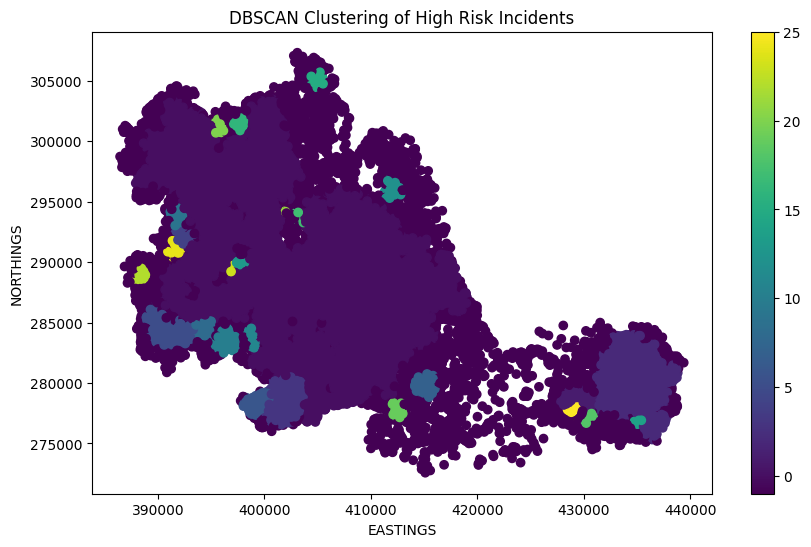

In [13]:
dbscan_clutstering(high_risk, 500, 50, 'DBSCAN Clustering of High Risk Incidents')

In [7]:
def dbscan(df, eps, min_samples, plot_title):
    coords = df[['X', 'Y']].values
    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Add the cluster labels to the DataFrame
    df['cluster'] = db.labels_

    # Plot the clustered data
    plt.figure(figsize=(10, 6))

    # Scatter plot of the points
    plt.scatter(df['X'], df['Y'], c=df['cluster'], cmap='viridis', marker='o')
    # add color bar legend
    plt.colorbar()

    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.title(plot_title)

    plt.show()

In [14]:
dbscan(high_risk, 100, 10, 'DBSCAN Clustering of EASTINGS and NORTHINGS High Risk Incidents')

MemoryError: 

In [18]:

def dbscan_clustering(df, eps, min_samples, plot_title):
    # Coordinate transformation from EPSG 27700 to EPSG 4326
    in_proj = Proj(init='epsg:27700')
    out_proj = Proj(init='epsg:4326')

    def transform_coords(row):
        lon, lat = transform(in_proj, out_proj, row['EASTINGS'], row['NORTHINGS'])
        return pd.Series({'X': lon, 'Y': lat})

    df[['X', 'Y']] = df.apply(transform_coords, axis=1)

    coords = df[['X', 'Y']].values

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Add the cluster labels to the DataFrame
    df['cluster'] = db.labels_

    # Plot the clustered data
    plt.figure(figsize=(10, 6))

    # Scatter plot of the points
    plt.scatter(df['X'], df['Y'], c=df['cluster'], cmap='viridis', marker='o')
    # Add color bar legend
    plt.colorbar()

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(plot_title)

    plt.show()



In [53]:
def dbscan_clutstering(df, eps, min_samples, plot_title):
    coords = df['geometry'].values
    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Add the cluster labels to the DataFrame
    df['cluster'] = db.labels_

    # Plot the clustered data
    plt.figure(figsize=(10, 6))

    # Scatter plot of the points
    plt.scatter(df['geometry'], c=df['cluster'], cmap='viridis', marker='o')
    # add color bar legend
    plt.colorbar()

    # Add labels and title
    plt.xlabel('EASTINGS')
    plt.ylabel('NORTHINGS')

    plt.title(plot_title)

    plt.show()

In [47]:
def dbscan_clustering(df, eps, min_samples, plot_title):
    # Coordinate transformation from EPSG 27700 to EPSG 4326
    in_proj = Proj(init='epsg:27700')
    out_proj = Proj(init='epsg:4326')

    def transform_coords(row):
        lon, lat = transform(in_proj, out_proj, row['EASTINGS'], row['NORTHINGS'])
        return pd.Series({'LON': lon, 'LAT': lat})

    df[['LON', 'LAT']] = df.apply(transform_coords, axis=1)

    coords = df[['LON', 'LAT']].values

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Add the cluster labels to the DataFrame
    df['cluster'] = db.labels_

    # Plot the clustered data
    plt.figure(figsize=(10, 6))

    # Scatter plot of the points
    plt.scatter(df['geometry'], c=df['cluster'], cmap='viridis', marker='o')
    # add color bar legend
    plt.colorbar()

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(plot_title)

    plt.show()


In [9]:
dbscan_clutstering(high_risk, 500, 50, 'DBSCAN Clustering of High Risk Incidents')

NameError: name 'dbscan_clutstering' is not defined

In [35]:
# Extract the EASTINGS and NORTHINGS columns
coordinates = high_risk[['X', 'Y']].dropna()

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=300, min_samples=10)
dbscan.fit(coordinates)

# Add the cluster labels to the data
coordinates['Cluster'] = dbscan.labels_

# Plot the clusters
plt.figure(figsize=(18, 8))
plt.scatter(coordinates['X'], coordinates['Y'], c=coordinates['Cluster'], cmap='plasma', marker='o', s=1)
plt.title('DBSCAN Clustering of False Alarms (Equipment)')
plt.xlabel('EASTINGS')
plt.ylabel('NORTHINGS')
plt.colorbar(label='Cluster Label')
plt.show()

# Display the result
print(coordinates.head())

MemoryError: 